In [ ]:
from projection.registry import ProjectionRegistry
import numpy as np
# Create Mercator projection
mercator_proj = ProjectionRegistry.get_projection("mercator", R=6371, lat_min=-85, lat_max=85)

# Test forward projection
lon = np.array([-180, -90, 0, 90, 180])
lat = np.array([-85, -45, 0, 45, 85])
x, y = mercator_proj.create_projection().forward(lon, lat)
print(f"Forward: x={x}, y={y}")

# Test backward projection
lon_back, lat_back, mask = mercator_proj.create_projection().backward(x, y)
print(f"Backward: lon={lon_back}, lat={lat_back}, mask={mask}")

In [1]:
%load_ext autoreload
%autoreload 2

2025-01-03 06:55:15,160 - gnomonic_projection.gnomonic.config - INFO - GnomonicConfig initialized successfully.
2025-01-03 06:55:15,160 - gnomonic_projection.gnomonic.strategy - INFO - GnomonicProjectionStrategy initialized successfully.
2025-01-03 06:55:15,161 - gnomonic_projection.gnomonic.grid - INFO - GnomonicGridGeneration initialized successfully.
2025-01-03 06:55:15,161 - gnomonic_projection.base.interpolation - INFO - BaseInterpolation initialized successfully.
2025-01-03 06:55:15,162 - gnomonic_projection.gnomonic.transform - INFO - GnomonicTransformer initialized successfully.
2025-01-03 06:55:15,162 - gnomonic_projection.processor - INFO - ProjectionProcessor components initialized successfully.
2025-01-03 06:55:15,167 - gnomonic_projection.base.interpolation - INFO - Image interpolation completed successfully.
2025-01-03 06:55:15,167 - gnomonic_projection.processor - INFO - Forward projection completed successfully.
Gnomonic Rectilinear image saved to results/gnomonic_recti

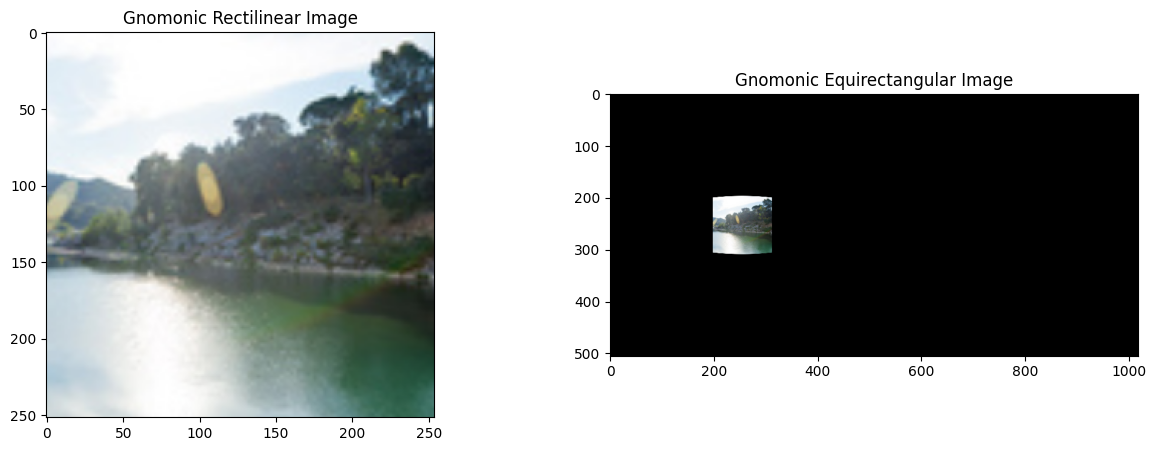

In [18]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import matplotlib.pyplot as plt

def test_gnomonic_projection(image_path: str, output_dir: str):
    """
    Test the Gnomonic projection system by performing forward and backward projections.

    Args:
        image_path (str): Path to the input equirectangular image.
        output_dir (str): Directory to save the output images.
    """
    # Step 1: Load the equirectangular image
    equirect_img = cv2.imread(image_path)
    if equirect_img is None:
        raise RuntimeError(f"Failed to load the image at {image_path}.")
    H, W, _ = equirect_img.shape

    # Convert the image from BGR to RGB
    equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)

    # Step 2: Retrieve and instantiate a Gnomonic projection processor
    processor = ProjectionRegistry.get_projection(
        "gnomonic",
        return_processor=True,
        phi1_deg=0,
        lam0_deg=-90,
        lat_points=H,
        lon_points=W,
        x_points=W // 4,
        y_points=H // 2,
        fov_deg=40
    )

    # Step 3: Perform forward projection to rectilinear
    rectilinear_img = processor.forward(equirect_img)
    rectilinear_path = f"{output_dir}/gnomonic_rectilinear.png"
    cv2.imwrite(rectilinear_path, cv2.cvtColor(rectilinear_img, cv2.COLOR_RGB2BGR))
    print(f"Gnomonic Rectilinear image saved to {rectilinear_path}")

    # Step 4: Perform backward projection to equirectangular
    equirectangular_img = processor.backward(
        rectilinear_img,
        return_mask=True,
    )
    equirectangular_path = f"{output_dir}/gnomonic_equirectangular.png"
    cv2.imwrite(equirectangular_path, cv2.cvtColor(equirectangular_img, cv2.COLOR_RGB2BGR))
    print(f"Gnomonic Equirectangular image saved to {equirectangular_path}")

    # Step 5: Mask pixels outside the projection area
    mask = np.mean(equirectangular_img, axis=-1) > 0

    # Step 6: Compute the Mean Absolute Error (MAE)
    mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
    mae = np.mean(mae_img[mask])
    print(f"Gnomonic Projection Mean Absolute Error: {mae}")

    # Step 7: Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Gnomonic Rectilinear Image")
    plt.imshow(rectilinear_img)

    plt.subplot(1, 2, 2)
    plt.title("Gnomonic Equirectangular Image")
    plt.imshow(equirectangular_img)

    plt.show()

test_gnomonic_projection(image_path="data/image1.png", output_dir="results")

In [ ]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import matplotlib.pyplot as plt

def test_mercator_projection(image_path: str, output_dir: str):
    """
    Test the Mercator projection system by performing forward and backward projections.

    Args:
        image_path (str): Path to the input equirectangular image.
        output_dir (str): Directory to save the output images.
    """
    # Step 1: Load the equirectangular image
    equirect_img = cv2.imread(image_path)
    if equirect_img is None:
        raise RuntimeError(f"Failed to load the image at {image_path}.")
    H, W, _ = equirect_img.shape

    # Convert the image from BGR to RGB
    equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)
    plt.imshow(equirect_img)
    plt.show()

    # Step 2: Retrieve and instantiate a Mercator projection processor
    processor = ProjectionRegistry.get_projection(
        "mercator",
        return_processor=True,
        R=1,  # Earth's radius in kilometers
        lon_min=-180,
        lon_max=180,
        lat_min=-85,
        lat_max=85,
        x_points=W,
        y_points=H
    )

    # Step 3: Perform forward projection to rectilinear
    rectilinear_img = processor.forward(equirect_img)
    rectilinear_path = f"{output_dir}/mercator_rectilinear.png"
    cv2.imwrite(rectilinear_path, cv2.cvtColor(rectilinear_img, cv2.COLOR_RGB2BGR))
    print(f"Mercator Rectilinear image saved to {rectilinear_path}")

    # Step 4: Perform backward projection to equirectangular
    equirectangular_img = processor.backward(
        rectilinear_img,
        return_mask=True,
    )
    equirectangular_path = f"{output_dir}/mercator_equirectangular.png"
    cv2.imwrite(equirectangular_path, cv2.cvtColor(equirectangular_img, cv2.COLOR_RGB2BGR))
    print(f"Mercator Equirectangular image saved to {equirectangular_path}")

    # Step 5: Mask pixels outside the projection area
    mask = np.mean(equirectangular_img, axis=-1) > 0

    # Step 6: Compute the Mean Absolute Error (MAE)
    mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
    mae = np.mean(mae_img[mask])
    print(f"Mercator Projection Mean Absolute Error: {mae}")

    # Step 7: Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Mercator Rectilinear Image")
    plt.imshow(rectilinear_img)
    print(rectilinear_img.max())

    plt.subplot(1, 2, 2)
    plt.title("Mercator Equirectangular Image")
    plt.imshow(equirectangular_img)

    plt.show()
    return rectilinear_img, equirectangular_img, mask

rectilinear_img , equirectangular_img, mask = test_mercator_projection(image_path="data/image1.png", output_dir="results")



In [ ]:
x = np.linspace(-np.pi, np.pi, 1000)
y = np.linspace(-(85/190)*np.pi,(85/190)*np.pi ,200)
lon, lat = np.meshgrid(x, y)


# Convert degrees to radians
lon_rad = lon
lat_rad = lat


# Calculate x and y using Mercator projection formula
x = 1 * lon_rad
y = 1 * np.log(np.tan(np.pi / 4 + lat_rad / 2))

In [ ]:
y_max = np.log(np.tan(np.pi / 4 + np.radians(85) / 2))
y_min = np.log(np.tan(np.pi / 4 + np.radians(-85) / 2))
x = np.linspace(-np.pi, np.pi, 1000)
y = np.linspace(-y_min,y_max ,200)

# Calculate longitude and latitude
lon = np.degrees(x / 1)
lat = np.degrees( np.pi / 2 - 2 * np.arctan(np.e**(y / 1)))




In [ ]:
np.rad2deg(x)

In [ ]:
import unittest
import numpy as np
from projection.mercator.transform import MercatorTransformer
from projection.mercator.config import MercatorConfig
from projection.mercator.exceptions import ConfigurationError, TransformationError

class TestMercatorTransformer(unittest.TestCase):
    def setUp(self):
        # Sample configuration
        self.config = MercatorConfig(
            R=6371.0,
            lon_min=-180.0,
            lon_max=180.0,
            lat_min=-85.0,
            lat_max=85.0,
            x_points=1024,
            y_points=512,
            fov_deg=90.0
        )
        self.transformer = MercatorTransformer(self.config)

    def test_latlon_to_image_coords_center(self):
        # Test the center of the map
        lat = np.array([0.0])
        lon = np.array([0.0])
        shape = (512, 1024)
        map_x, map_y = self.transformer.latlon_to_image_coords(lat, lon, shape)
        self.assertAlmostEqual(map_x[0], 512, delta=1)
        self.assertAlmostEqual(map_y[0], 256, delta=1)

    def test_latlon_to_image_coords_north_pole(self):
        # Test near the northern limit
        lat = np.array([85.0])
        lon = np.array([0.0])
        shape = (512, 1024)
        map_x, map_y = self.transformer.latlon_to_image_coords(lat, lon, shape)
        self.assertAlmostEqual(map_y[0], 0, delta=1)  # Top of the image

    def test_latlon_to_image_coords_south_pole(self):
        # Test near the southern limit
        lat = np.array([-85.0])
        lon = np.array([0.0])
        shape = (512, 1024)
        map_x, map_y = self.transformer.latlon_to_image_coords(lat, lon, shape)
        self.assertAlmostEqual(map_y[0], 511, delta=1)  # Bottom of the image

    def test_xy_to_image_coords_center(self):
        # Test the center of the grid
        x = np.array([0.0])  # Assuming lon_min = -180, lon_max = 180
        y = np.array([0.0])  # Mercator y at lat=0
        shape = (512, 1024)
        map_x, map_y = self.transformer.xy_to_image_coords(x, y, shape)
        self.assertAlmostEqual(map_x[0], 512, delta=1)
        self.assertAlmostEqual(map_y[0], 256, delta=1)

    def test_invalid_latlon_input(self):
        # Test invalid input types
        with self.assertRaises(TypeError):
            self.transformer.latlon_to_image_coords("invalid_lat", np.array([0.0]), (512, 1024))

    def test_missing_configuration_attribute(self):
        # Test missing 'R' in configuration
        incomplete_config = MercatorConfig(
            R=6371.0,  # Remove this line to simulate missing 'R'
            lon_min=-180.0,
            lon_max=180.0,
            lat_min=-85.0,
            lat_max=85.0,
            x_points=1024,
            y_points=512,
            fov_deg=90.0
        )
        # Assuming 'R' is removed
        with self.assertRaises(ConfigurationError):
            MercatorTransformer(incomplete_config)

if __name__ == '__main__':
    unittest.main()

In [ ]:
import cv2
from projection.registry import ProjectionRegistry
from projection.processor import ProjectionProcessor

# Step 1: Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H,W,_ = equirect_img.shape
# Step 2: Retrieve and instantiate a Gnomonic projection config 
processor = ProjectionRegistry.get_projection("gnomonic", return_processor=True,  
                                              phi1_deg=0, 
                                              lam0_deg=0, 
                                              lat_points=H,
                                              lon_points=W,
                                              x_points=W//4,
                                              y_points=H//2,
                                              fov_deg=90)

# Step 4: Perform forward projection to rectilinear
rectilinear_img = processor.forward(equirect_img, phi1_deg=0, lam0_deg=0, fov_deg=(60, 60))
cv2.imwrite("rectilinear.png", rectilinear_img)

# Step 5: Perform backward projection to equirectangular
equirectangular_img = processor.backward(
    rectilinear_img,
    img_shape=equirect_img.shape,
    phi1_deg=0,
    lam0_deg=0,
    fov_deg=(60, 60),
    return_mask=True,
)
cv2.imwrite("equirectangular.png", equirectangular_img)

import matplotlib.pyplot as plt
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)
plt.show()

In [ ]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
from projection.processor import ProjectionProcessor

# Step 1: Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H,W,_ = equirect_img.shape

# Convert the image from BGR to RGB
equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)

# Step 2: Retrieve and instantiate a Gnomonic projection config 
processor = ProjectionRegistry.get_projection("gnomonic", return_processor=True,  
                                              phi1_deg=0, 
                                              lam0_deg=90, 
                                              lat_points=H,
                                              lon_points=W,
                                              x_points=W//4,
                                              y_points=H//2,
                                              fov_deg=50)

# Step 4: Perform forward projection to rectilinear
rectilinear_img = processor.forward(equirect_img)
cv2.imwrite("rectilinear.png", rectilinear_img)

# Step 5: Perform backward projection to equirectangular
equirectangular_img = processor.backward(
    rectilinear_img,
    return_mask=True,
)

# Step 6: Mask pixels outside the projection area
mask = np.mean(equirectangular_img,axis=-1) > 0

# Step 7: Compute the Mean Absolute Error 
mae_img = np.abs(equirect_img * mask[:,:,None] - equirectangular_img)
mae = np.mean(mae_img[mask]) 
print(mae)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mae_img )
plt.show()
plt.imshow(rectilinear_img)
plt.show()
plt.imshow(equirectangular_img)

In [ ]:
equirectangular_img.max()

In [ ]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry

# Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H, W, _ = equirect_img.shape

# Convert the image from BGR to RGB
equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)

# Define the parameter grid
phi1_range = np.linspace(-90, 90, num=10)  # 10 steps from -90 to 90 degrees
lam0_range = np.linspace(-180, 180, num=10)  # 10 steps from -180 to 180 degrees
fov_range = np.linspace(10, 90, num=5)  # 5 steps from 10 to 90 degrees

# Initialize a dictionary to store results
results = []

# Perform the experiment
for phi1_deg in phi1_range:
    for lam0_deg in lam0_range:
        for fov_deg in fov_range:
            try:
                # Step 2: Instantiate the projection processor
                processor = ProjectionRegistry.get_projection(
                    "gnomonic",
                    return_processor=True,
                    phi1_deg=phi1_deg,
                    lam0_deg=lam0_deg,
                    lat_points=H,
                    lon_points=W,
                    x_points=W // 4,
                    y_points=H // 2,
                    fov_deg=fov_deg,
                )

                # Step 3: Perform forward projection to rectilinear
                rectilinear_img = processor.forward(equirect_img)

                # Step 4: Perform backward projection to equirectangular
                equirectangular_img = processor.backward(rectilinear_img, return_mask=True)

                # Step 5: Mask pixels outside the projection area
                mask = np.mean(equirectangular_img, axis=-1) > 0

                # Step 6: Compute the Mean Absolute Error
                mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
                mae = np.mean(mae_img[mask])

                # Store the result
                results.append({
                    "phi1_deg": phi1_deg,
                    "lam0_deg": lam0_deg,
                    "fov_deg": fov_deg,
                    "mae": mae
                })

                print(f"phi1_deg={phi1_deg}, lam0_deg={lam0_deg}, fov_deg={fov_deg}, MAE={mae}")

            except Exception as e:
                print(f"Error at phi1_deg={phi1_deg}, lam0_deg={lam0_deg}, fov_deg={fov_deg}: {e}")

# Save results to a file
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv("experiment_results.csv", index=False)

print("Experiment completed. Results saved to 'experiment_results.csv'.")

In [ ]:
import numpy as np
import cv2
from projection.registry import ProjectionRegistry
import pandas as pd

# Load the equirectangular image
equirect_img = cv2.imread("data/image1.png")
if equirect_img is None:
    raise RuntimeError("Failed to load the image.")
H, W, _ = equirect_img.shape

# Convert the image from BGR to RGB
equirect_img = cv2.cvtColor(equirect_img, cv2.COLOR_BGR2RGB)

# Define the parameter grid
phi1_range = np.linspace(-90, 90, num=10)  # 10 steps from -90 to 90 degrees
lam0_range = np.linspace(-180, 180, num=10)  # 10 steps from -180 to 180 degrees
fov_range = np.linspace(10, 90, num=5)  # 5 steps from 10 to 90 degrees
interpolation_options = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4]
border_modes = [cv2.BORDER_CONSTANT, cv2.BORDER_REPLICATE, cv2.BORDER_REFLECT, cv2.BORDER_REFLECT_101]

# Initialize a list to store results
results = []

# Perform the experiment
for phi1_deg in phi1_range:
    for lam0_deg in lam0_range:
        for fov_deg in fov_range:
            for interpolation in interpolation_options:
                for border_mode in border_modes:
                    try:
                        # Step 2: Instantiate the projection processor
                        processor = ProjectionRegistry.get_projection(
                            "gnomonic",
                            return_processor=True,
                            phi1_deg=phi1_deg,
                            lam0_deg=lam0_deg,
                            lat_points=H,
                            lon_points=W,
                            x_points=W // 4,
                            y_points=H // 2,
                            fov_deg=fov_deg,
                            interpolation=interpolation,
                            borderMode=border_mode,
                            borderValue=(255, 0, 0),  # Example: Red border for constant mode
                        )

                        # Step 3: Perform forward projection to rectilinear
                        rectilinear_img = processor.forward(equirect_img)

                        # Step 4: Perform backward projection to equirectangular
                        equirectangular_img = processor.backward(rectilinear_img, return_mask=True)

                        # Step 5: Mask pixels outside the projection area
                        mask = np.mean(equirectangular_img, axis=-1) > 0

                        # Step 6: Compute the Mean Absolute Error
                        mae_img = np.abs(equirect_img * mask[:, :, None] - equirectangular_img)
                        mae = np.mean(mae_img[mask])

                        # Store the result
                        results.append({
                            "phi1_deg": phi1_deg,
                            "lam0_deg": lam0_deg,
                            "fov_deg": fov_deg,
                            "interpolation": interpolation,
                            "border_mode": border_mode,
                            "mae": mae
                        })

                        print(
                            f"phi1_deg={phi1_deg}, lam0_deg={lam0_deg}, fov_deg={fov_deg}, "
                            f"interpolation={interpolation}, border_mode={border_mode}, MAE={mae}"
                        )

                    except Exception as e:
                        print(
                            f"Error at phi1_deg={phi1_deg}, lam0_deg={lam0_deg}, fov_deg={fov_deg}, "
                            f"interpolation={interpolation}, border_mode={border_mode}: {e}"
                        )

# Save results to a file
results_df = pd.DataFrame(results)
results_df.to_csv("experiment_results.csv", index=False)

print("Experiment completed. Results saved to 'experiment_results.csv'.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load the experimental results
df = pd.read_csv("experiment_results.csv")

# Normalize the MAE column
min_mae = df["mae"].min()
max_mae = df["mae"].max()
df["normalized_mae"] = (df["mae"] - min_mae) / (max_mae - min_mae)

# Ensure the normalization
print(f"Min Normalized MAE: {df['normalized_mae'].min()}, Max Normalized MAE: {df['normalized_mae'].max()}")

# Set global style
sns.set_style("whitegrid")

# 1. Line Charts for Each Parameter vs. Normalized MAE
parameters = ["phi1_deg", "lam0_deg", "fov_deg"]
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x=param, y="normalized_mae")
    plt.title(f"Normalized MAE vs {param}")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.show()

# 2. Box Plots for Each Parameter
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=param, y="normalized_mae")
    plt.title(f"Normalized MAE Distribution by {param}")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.show()

# 3. Heatmaps for Pairwise Parameter Interactions
pairs = [("phi1_deg", "lam0_deg"), ("phi1_deg", "fov_deg"), ("lam0_deg", "fov_deg")]

for param1, param2 in pairs:
    plt.figure(figsize=(10, 8))
    pivot = df.pivot_table(index=param1, columns=param2, values="normalized_mae", aggfunc="mean")
    sns.heatmap(pivot, cmap="viridis", annot=False)
    plt.title(f"Normalized MAE Heatmap: {param1} vs {param2}")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.tight_layout()
    plt.show()

# 4. 3D Surface Plots
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Example: phi1_deg vs lam0_deg vs normalized_mae
x = df["phi1_deg"]
y = df["lam0_deg"]
z = df["normalized_mae"]

scatter = ax.scatter(x, y, z, c=z, cmap="viridis", marker="o")
ax.set_title("3D Surface: phi1_deg vs lam0_deg vs Normalized MAE")
ax.set_xlabel("phi1_deg")
ax.set_ylabel("lam0_deg")
ax.set_zlabel("Normalized MAE")
plt.colorbar(scatter, ax=ax, label="Normalized MAE")
plt.show()

# 5. Violin Plots for Each Parameter
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df, x=param, y="normalized_mae", scale="width")
    plt.title(f"Violin Plot: {param} vs Normalized MAE")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.show()

# 6. General Distribution: Histogram of Normalized MAE
plt.figure(figsize=(8, 5))
sns.histplot(df["normalized_mae"], bins=20, kde=True, color="blue")
plt.title("Histogram of Normalized MAE")
plt.xlabel("Normalized Mean Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm
from scipy.interpolate import griddata

# Load the experimental results
df = pd.read_csv("experiment_results.csv")

# Normalize the MAE column
min_mae = df["mae"].min()
max_mae = df["mae"].max()
df["normalized_mae"] = (df["mae"] - min_mae) / (max_mae - min_mae)

# Ensure the normalization
print(f"Min Normalized MAE: {df['normalized_mae'].min()}, Max Normalized MAE: {df['normalized_mae'].max()}")

# Set global style
sns.set_style("whitegrid")

# 1. Line Charts for Each Parameter vs. Normalized MAE
parameters = ["phi1_deg", "lam0_deg", "fov_deg"]
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df, x=param, y="normalized_mae", ci="sd")
    plt.title(f"Normalized MAE vs {param}")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.savefig(f"lineplot_{param}.png")
    plt.show()

# 2. Box Plots for Each Parameter
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=param, y="normalized_mae")
    plt.title(f"Normalized MAE Distribution by {param}")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.savefig(f"boxplot_{param}.png")
    plt.show()

# 3. Heatmaps for Pairwise Parameter Interactions
pairs = [("phi1_deg", "lam0_deg"), ("phi1_deg", "fov_deg"), ("lam0_deg", "fov_deg")]

for param1, param2 in pairs:
    plt.figure(figsize=(10, 8))
    pivot = df.pivot_table(index=param1, columns=param2, values="normalized_mae", aggfunc="mean")
    sns.heatmap(pivot, cmap="viridis", annot=True, fmt=".2f", cbar_kws={"label": "Normalized MAE"})
    plt.title(f"Normalized MAE Heatmap: {param1} vs {param2}")
    plt.xlabel(param2)
    plt.ylabel(param1)
    plt.tight_layout()
    plt.savefig(f"heatmap_{param1}_vs_{param2}.png")
    plt.show()

# 4. 3D Surface Plots with Interpolation
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df["phi1_deg"]
y = df["lam0_deg"]
z = df["normalized_mae"]

# Interpolate for a smooth surface
xi, yi = np.meshgrid(
    np.linspace(x.min(), x.max(), 50),
    np.linspace(y.min(), y.max(), 50)
)
zi = griddata((x, y), z, (xi, yi), method="cubic")

# Plot surface
surf = ax.plot_surface(xi, yi, zi, cmap=cm.viridis, alpha=0.7)
scatter = ax.scatter(x, y, z, c=z, cmap="viridis", marker="o")
ax.set_title("3D Surface: phi1_deg vs lam0_deg vs Normalized MAE")
ax.set_xlabel("phi1_deg")
ax.set_ylabel("lam0_deg")
ax.set_zlabel("Normalized MAE")
plt.colorbar(scatter, ax=ax, label="Normalized MAE")
plt.tight_layout()
plt.savefig("3d_surface_phi1_vs_lam0.png")
plt.show()

# 5. Violin Plots for Each Parameter
for param in parameters:
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=df, x=param, y="normalized_mae", scale="width")
    plt.title(f"Violin Plot: {param} vs Normalized MAE")
    plt.xlabel(param)
    plt.ylabel("Normalized Mean Absolute Error")
    plt.tight_layout()
    plt.savefig(f"violinplot_{param}.png")
    plt.show()

# 6. General Distribution: Histogram of Normalized MAE
plt.figure(figsize=(8, 5))
sns.histplot(df["normalized_mae"], bins=20, kde=True, kde_kws={"bw_adjust": 0.5}, color="blue")
plt.title("Histogram of Normalized MAE")
plt.xlabel("Normalized Mean Absolute Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("histogram_normalized_mae.png")
plt.show()